# SHAP-Style Plots  Documentation

This notebook is designed to demonstrate how to use `pymint` to plot [SHAP-style](https://github.com/slundberg/shap) plots within MintPy. For more information on dataset and initializing `InterpretToolkit`, see the permutatation importance notebook.

In [1]:
import sys, os 
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
sys.path.append(path)
import numpy as np
import pandas as pd
import shap

In [2]:
import pymint
import plotting_config 

### Loading the training data and pre-fit models 


In [3]:
estimators, estimator_names = pymint.load_models()
X,_ = pymint.load_data()

In [4]:
X_subset = shap.sample(X, 50, random_state=42)
explainer = pymint.InterpretToolkit(estimators,estimator_names=estimator_names, X=X_subset,)

### Compute the Shap Values 

In [5]:
background_dataset = shap.sample(X, 100)
results = explainer.shap(background_dataset=background_dataset)

trying TreeExplainer...


 95%|=================== | 95/100 [00:20<00:01]       

trying TreeExplainer...
trying TreeExplainer...
TreeExplainer failed, starting KernelExplainer...


In [6]:
shap_values, bias = results['Random Forest']

## Summary Plot

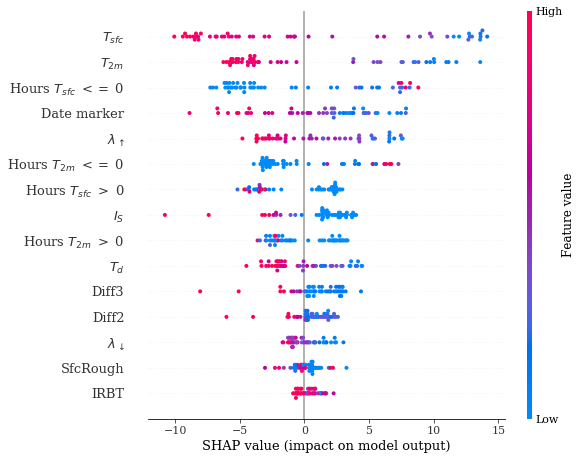

In [7]:
explainer.plot_shap(
                    plot_type = 'summary',
                    shap_values=shap_values,
                    display_feature_names=plotting_config.display_feature_names,
)                           

### Dependence Plot

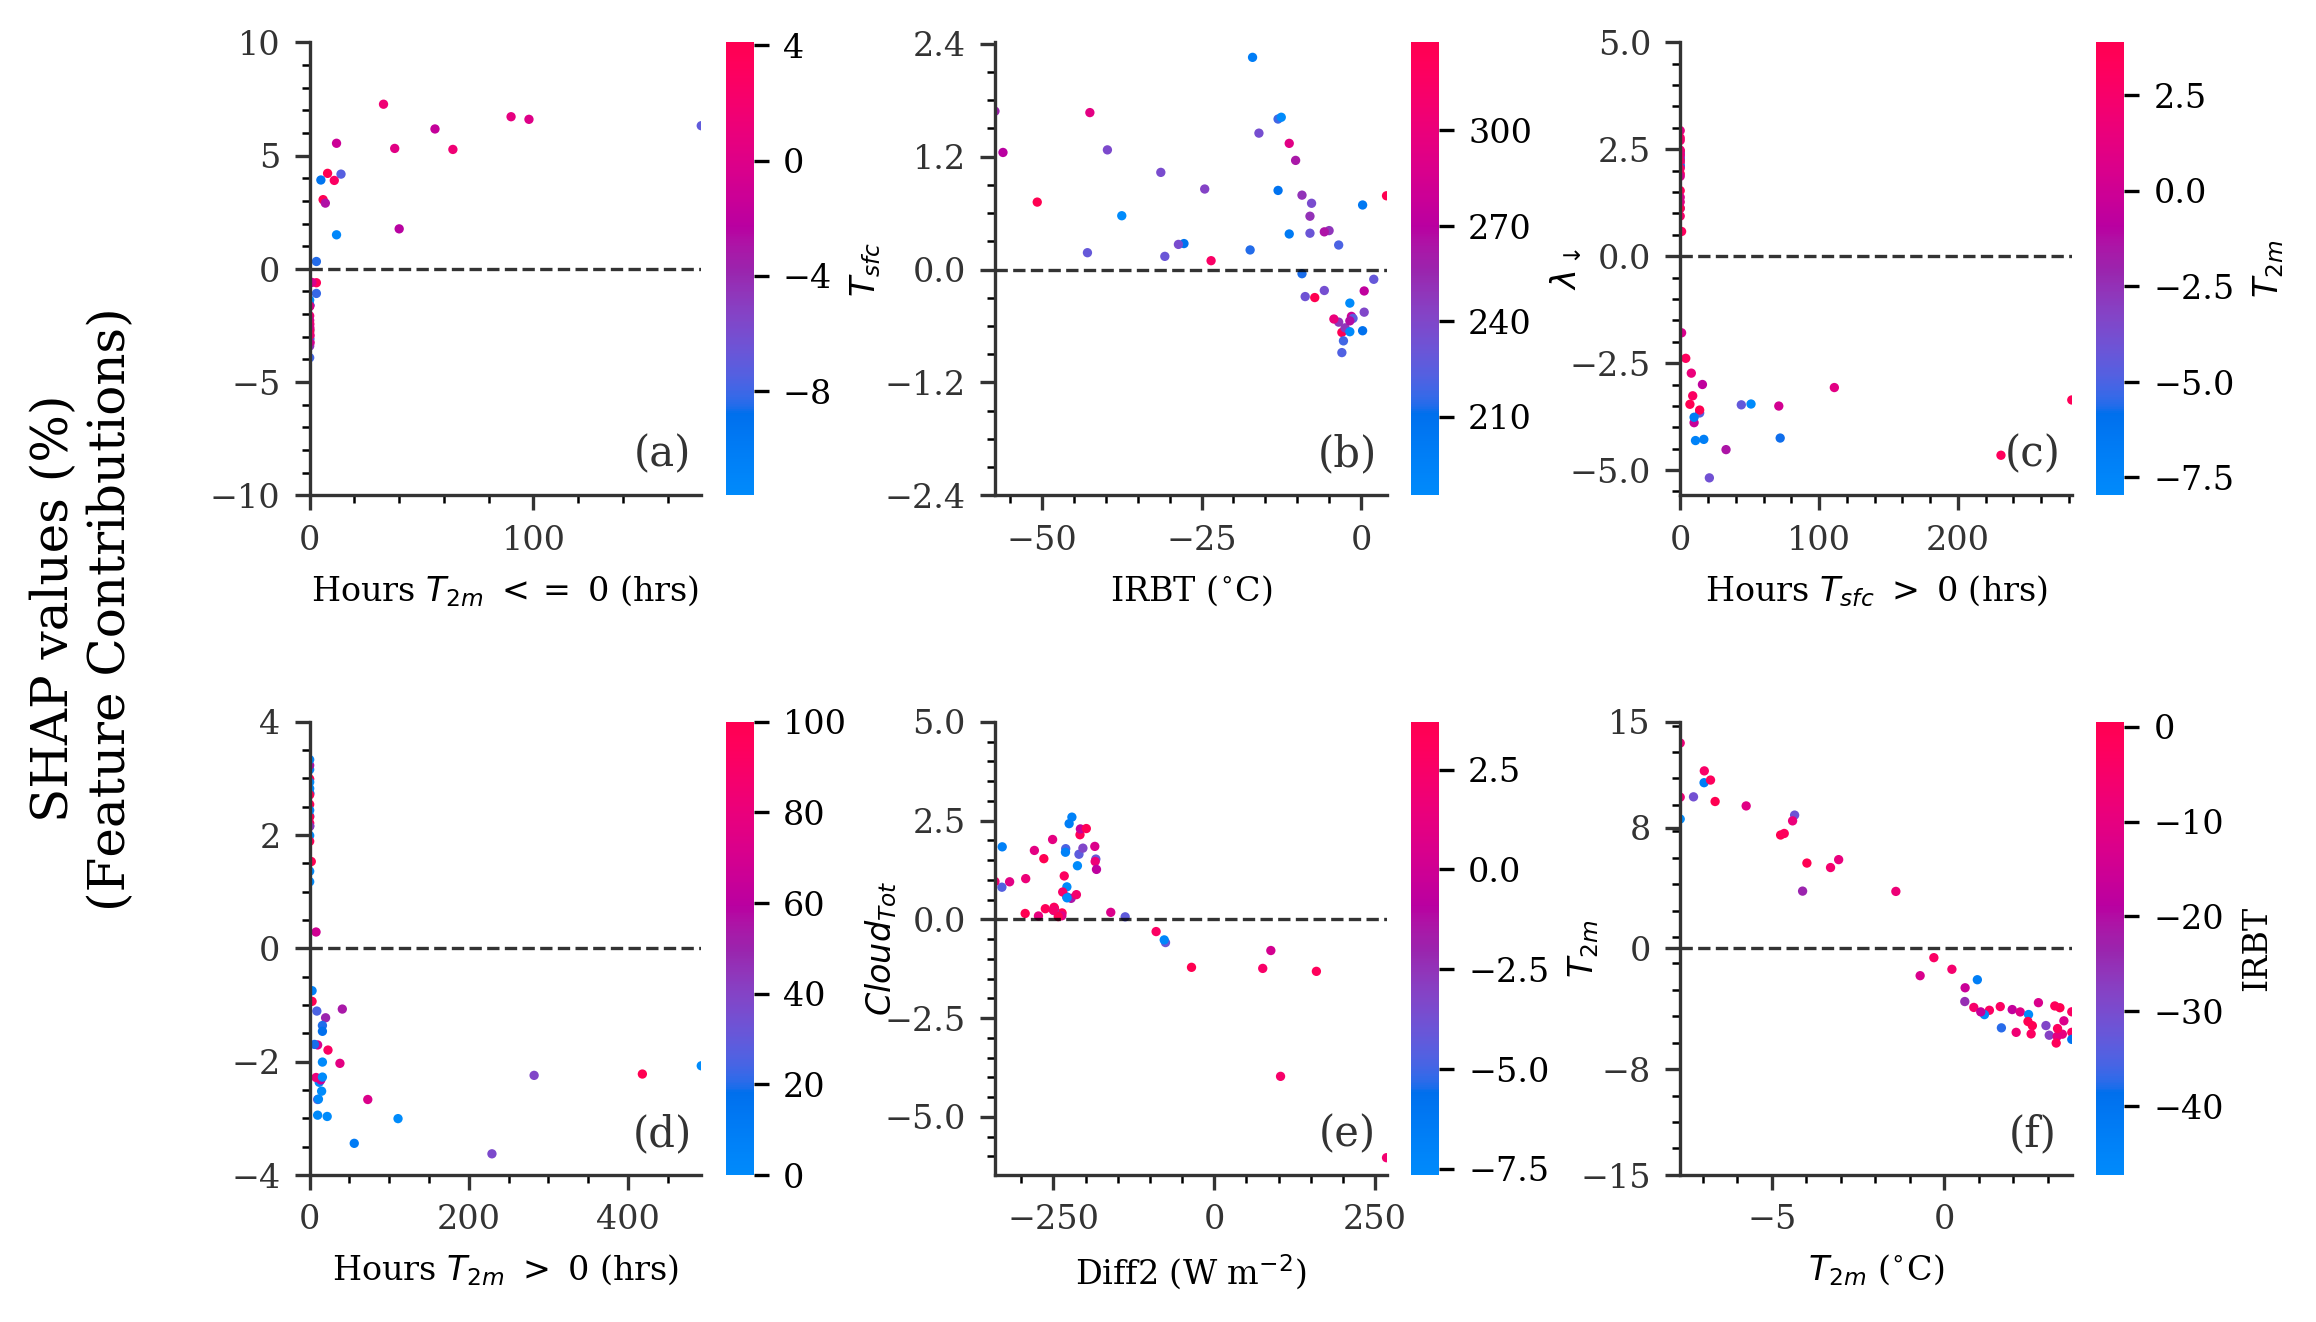

In [8]:
features = ['tmp2m_hrs_bl_frez', 'sat_irbt', 'sfcT_hrs_ab_frez', 'tmp2m_hrs_ab_frez', 'd_rad_d', 'temp2m']
explainer.plot_shap(features=features,
                        plot_type = 'dependence',
                        shap_values=shap_values,
                        display_feature_names=plotting_config.display_feature_names,
                        display_units = plotting_config.display_units,
)

## SHAP for Regression

In [9]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor

In [10]:
data = fetch_california_housing()
X = data['data']
y = data['target']
feature_names = data['feature_names']
clf = RandomForestRegressor()
clf.fit(X,y)

RandomForestRegressor()

In [11]:
X_subset = shap.sample(X, 100, random_state=42)
explainer = pymint.InterpretToolkit(clf,'Random Forest',X=X_subset, feature_names=feature_names)

trying TreeExplainer...


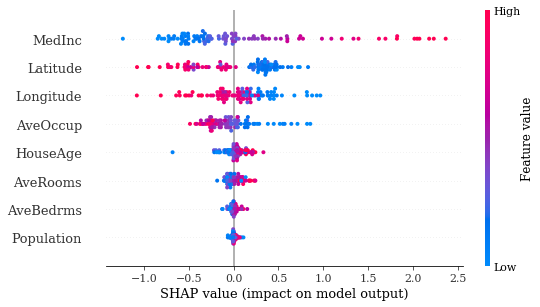

In [13]:
background_dataset = shap.sample(X, 100)
results = explainer.shap(background_dataset=background_dataset)
shap_values, bias = results['Random Forest']
explainer.plot_shap(
                    plot_type = 'summary',
                    shap_values=shap_values,
                    display_feature_names=plotting_config.display_feature_names,
)                           